# Predicting phylum level taxonomic identity of organisms based on codon usage levels

---

Given the advances in technologies and decrease in sequencing costs over the past 2 decades, the ability to sequence unknown organisms have become more accessible than ever. As of March 2021, there are 36,229,188 genomic entries for 108,257 species at Reference Sequence (RefSeq) database by National Center for Biotechnology Information (NCBI). Previous work done has utilize the abundance of information to predict taxonomic identity at the kingdom level (https://www.biorxiv.org/content/10.1101/2020.10.26.356295v1) with an old dataset. Here, I show that phylum level identity prediction is also doable with an updated dataset consisting of more organisms and sequences. 

## Install some required packages used in this entire notebook

---
The following python packages are used in this notebook. Run the below cell to install them if you have not done so.


In [ ]:
!pip install wget requests selenium biopython pandas scikit-learn matplotlib xgboost

## Data download process


---


The data is available from https://hive.biochemistry.gwu.edu/dna.cgi?cmd=tissue_codon_usage&id=586358&mode=cocoputs. The Refseq_species.tsv contains all the codon frequencies of many species from NCBI. Firstly I tried to download via the download link with wget.

In [ ]:
import os
import wget
print(myfile)
data_folder = "./data"
filename = "codon_usage.tsv"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
filepath = os.path.join(data_folder,filename)
url = "https://hive.biochemistry.gwu.edu/dna.cgi?cmd=objFile&ids=586358&filename=Refseq_species.tsv&raw=1"
wget.download(url, filepath)
with open("data/codon_usage.tsv", "r") as f:
    print(f.readlines())

<Response [200]>
[]


However, the above approach did not work and returned an empty file. After examining the download process with the developers tool in Google Chrome, I realise it requires some headers for the GET request. I tried the below copying the headers in but it still did not work.

In [ ]:
import requests
headers = {
"Host": "hive.biochemistry.gwu.edu",
"Connection": "keep-alive",
"sec-ch-ua": '"Google Chrome";v="89", "Chromium";v="89", ";Not A Brand";v="99"',
"sec-ch-ua-mobile": "?0",
"Upgrade-Insecure-Requests": "1",
"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36",
"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
"Sec-Fetch-Site": "same-origin",
"Sec-Fetch-Mode": "navigate",
"Sec-Fetch-User": "?1",
"Sec-Fetch-Dest": "document",
"Referer": "https://hive.biochemistry.gwu.edu/dna.cgi?cmd=tissue_codon_usage&id=586358&mode=cocoputs",
"Accept-Encoding": "gzip, deflate, br",
"Accept-Language": "en-US,en;q=0.9",

"Range": "bytes=783482-783482",
"If-Range": "1578517013:86024007"}
myfile = requests.get("https://hive.biochemistry.gwu.edu/dna.cgi?cmd=objFile&ids=586358&filename=Refseq_species.tsv&raw=1", headers=headers)
print(myfile.content)

b''


Once again, it is empty. Hence, I resorted to using Selenium and navigating the browser. First, I downloaded the Chrome driver. Then, I used the browser developer tools to examine the webpage and copy the XPATH of the elements that have to be clicked. On normal navigation, it requires 2 clicks to initate the download of the file. 

In [ ]:
from zipfile import ZipFile
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

#downloading and extracting the chrome drive
wget.download("https://chromedriver.storage.googleapis.com/89.0.4389.23/chromedriver_win32.zip")
file_name = "chromedriver_win32.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()

driver = webdriver.Chrome(executable_path=r'./chromedriver.exe')
driver.get("https://hive.biochemistry.gwu.edu/dna.cgi?cmd=tissue_codon_usage&id=586358&mode=cocoputs")
timeout = 60
try:
    element_present = EC.presence_of_element_located((By.XPATH, '//*[@id="results"]/li[3]/a'))
    WebDriverWait(driver, timeout).until(element_present)
    download_tab = driver.find_element_by_xpath("/html/body/form[2]/div/div/div[4]/div[1]/div[1]/div[2]/ul/li[3]/ul/li[3]/a")
    download_tab.click()
    print("Clicked the first button!")
except TimeoutException:
    print ("Timed out waiting for page to load")

try:
    element_present = EC.presence_of_element_located((By.XPATH, '/html/body/form[2]/div/div/div[7]/div[1]/div[2]/div/div/div[2]/table/tbody/tr[18]/td[2]'))
    WebDriverWait(driver, timeout).until(element_present)
    download = driver.find_element_by_xpath('/html/body/form[2]/div/div/div[7]/div[1]/div[2]/div/div/div[2]/table/tbody/tr[18]/td[2]')
    download.click()
    print("Clicked the second tab!")
except TimeoutException:
    print ("Timed out waiting for page to load")

driver.close()

Clicked the first button!
Timed out waiting for page to load


However, this method ultimately did not work as the second table did not appear after clicking the first click. I was unable to make more progress due to my limited knowledge of HTML and JavaScript. Ultimately, I postulates that there are safeguards put in place to limit any automated downloading/conceal the download as they are an academic institute and may be afraid of request overload. I moved on by downloading the data manually from https://hive.biochemistry.gwu.edu/dna.cgi?cmd=tissue_codon_usage&id=586358&mode=cocoputs (as of 13th of March). 

## Data exploration

---


Here, we will look at how many entries are there in the file. 

In [128]:
import pandas as pd
#read in CoCoPUTs file
df = pd.read_table("data/o586358-Refseq_species.tsv",index_col=False,low_memory=False)
print(df.shape)
df.head()

(191025, 76)


,Division,Assembly,Taxid,Species,Organelle,Translation Table,# CDS,# Codons,GC%,GC1%,...,CGA,CGG,AGT,AGC,AGA,AGG,GGT,GGC,GGA,GGG
0,refseq,GCF_002287175.1,2161,Methanobacterium bryantii,genomic,11,3266,910953,35.52,45.52,...,2404,1515,12496,7687,14043,8418,18911,8417,26631,8789
1,refseq,GCF_000302455.1,1204725,Methanobacterium formicicum DSM 3637,genomic,11,2520,719599,40.88,49.69,...,2968,3068,10562,4882,8084,6214,17552,5296,21059,7069
2,refseq,GCF_000762265.1,2162,Methanobacterium formicicum,genomic,11,2376,678104,43.72,51.53,...,3067,5204,9335,4793,6499,5439,15945,5847,19130,7839
3,refseq,GCF_001458655.1,2162,Methanobacterium formicicum,genomic,11,2372,690178,43.50,51.30,...,3102,5182,9545,4797,6613,5472,16184,5887,19385,7934
4,refseq,GCF_000016525.1,420247,Methanobrevibacter smithii ATCC 35061,genomic,11,1757,557617,32.06,43.34,...,405,168,8234,3248,10191,2880,14664,2965,16981,2107


In [129]:
print(list(df))
print(df.iloc[:, 0:6].nunique())
df.iloc[:,4].unique()

['Division', 'Assembly', 'Taxid', 'Species', 'Organelle', 'Translation Table', '# CDS', '# Codons', 'GC%', 'GC1%', 'GC2%', 'GC3%', 'TTT', 'TTC', 'TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG', 'ATT', 'ATC', 'ATA', 'ATG', 'GTT', 'GTC', 'GTA', 'GTG', 'TAT', 'TAC', 'TAA', 'TAG', 'CAT', 'CAC', 'CAA', 'CAG', 'AAT', 'AAC', 'AAA', 'AAG', 'GAT', 'GAC', 'GAA', 'GAG', 'TCT', 'TCC', 'TCA', 'TCG', 'CCT', 'CCC', 'CCA', 'CCG', 'ACT', 'ACC', 'ACA', 'ACG', 'GCT', 'GCC', 'GCA', 'GCG', 'TGT', 'TGC', 'TGA', 'TGG', 'CGT', 'CGC', 'CGA', 'CGG', 'AGT', 'AGC', 'AGA', 'AGG', 'GGT', 'GGC', 'GGA', 'GGG']
Division                  1
Assembly             177439
Taxid                 59670
Species               59060
Organelle                 4
Translation Table        11
dtype: int64


array(['genomic', 'mitochondrion', 'chloroplast', 'plastid'], dtype=object)

As we can see here, we have 191025 samples with 76 variables. A quick glance at the number of unique values show that the data requires cleaning. Firstly, we have less unique assemblies than number of rows, meaning that some of the assemblies are repeated or NaN. Even though the number of species and taxid differs, here it is acceptable as we define each example based on the Assembly ID. We also have different type of DNA origins, here we focus on genomic DNA as those genes in mitochondrion, plastid or chloroplast might be shared between distantly related species and skew the differences. 

In [130]:
#show duplicated entries
df[df.duplicated(['Assembly'])]

,Division,Assembly,Taxid,Species,Organelle,Translation Table,# CDS,# Codons,GC%,GC1%,...,CGA,CGG,AGT,AGC,AGA,AGG,GGT,GGC,GGA,GGG
658,refseq,GCF_000513435.1,1173487,Halorubrum sp. AJ67,genomic,11,3078,763055,64.68,67.31,...,8366,17661,3223,10213,1988,2032,7707,29947,8715,16798
660,refseq,GCF_000513435.1,1173487,Halorubrum sp. AJ67,genomic,11,3083,764041,64.69,67.32,...,8369,17683,3223,10222,1988,2032,7711,30002,8725,16820
719,refseq,NaN,1407055,Candidatus Nitrosotenuis uzonensis,genomic,11,1,200,55.83,60.50,...,1,0,1,1,2,2,0,2,5,0
720,refseq,GCF_000723185.1,1407055,Candidatus Nitrosotenuis uzonensis,genomic,11,1876,493394,42.86,49.86,...,2243,824,3560,5730,9304,5257,6294,10132,12660,3397
4956,refseq,NaN,1354719,Helicobacter pylori HP87P7,genomic,11,4,1064,37.53,40.04,...,11,8,10,22,21,21,9,10,14,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191020,refseq,NaN,1923763,Xingshan nematode virus 4,genomic,0,5,3630,38.21,43.91,...,49,13,60,29,72,21,40,19,85,41
191021,refseq,NaN,1923772,Xinzhou nematode virus 4,genomic,0,5,3652,39.91,45.29,...,39,11,71,30,73,12,38,21,99,34
191022,refseq,NaN,1415147,Xylella phage Salvo,genomic,11,72,17848,63.15,62.21,...,58,140,30,344,10,22,163,993,71,109
191023,refseq,NaN,1415148,Xylella phage Sano,genomic,11,77,17851,62.46,61.59,...,71,137,41,340,10,24,185,993,74,95


Interestingly, there are multiple entries with the same assembly ID but differing number of coding sequences (# CDS). This may be due to the different gene open reading fram predictions from different softwares. To simplify the data, we shall only keep the assembly with the largest number of CDS. Furhtermore, we shall remove those without assembly IDs, as they are just draft collections of contigs without proper curated annotations. We also remove those with low number of codons.

In [131]:
df = df[df["Organelle"] == "genomic"] #keep genomic
df = df[df["Assembly"].notna()] #drop NaN
df = df[df["# Codons"] > 20000] #remove low codon counts
df = df.sort_values("# CDS", ascending=False).drop_duplicates("Assembly").sort_index()
print(df.shape)
df[df.duplicated(["Assembly"])]

(177437, 76)


,Division,Assembly,Taxid,Species,Organelle,Translation Table,# CDS,# Codons,GC%,GC1%,...,CGA,CGG,AGT,AGC,AGA,AGG,GGT,GGC,GGA,GGG


Looks like the data is cleaned! We shall check for any NAs just to be safe..

In [132]:
print(df.isnull().any().any())
df.head()

False


,Division,Assembly,Taxid,Species,Organelle,Translation Table,# CDS,# Codons,GC%,GC1%,...,CGA,CGG,AGT,AGC,AGA,AGG,GGT,GGC,GGA,GGG
0,refseq,GCF_002287175.1,2161,Methanobacterium bryantii,genomic,11,3266,910953,35.52,45.52,...,2404,1515,12496,7687,14043,8418,18911,8417,26631,8789
1,refseq,GCF_000302455.1,1204725,Methanobacterium formicicum DSM 3637,genomic,11,2520,719599,40.88,49.69,...,2968,3068,10562,4882,8084,6214,17552,5296,21059,7069
2,refseq,GCF_000762265.1,2162,Methanobacterium formicicum,genomic,11,2376,678104,43.72,51.53,...,3067,5204,9335,4793,6499,5439,15945,5847,19130,7839
3,refseq,GCF_001458655.1,2162,Methanobacterium formicicum,genomic,11,2372,690178,43.50,51.30,...,3102,5182,9545,4797,6613,5472,16184,5887,19385,7934
4,refseq,GCF_000016525.1,420247,Methanobrevibacter smithii ATCC 35061,genomic,11,1757,557617,32.06,43.34,...,405,168,8234,3248,10191,2880,14664,2965,16981,2107


## Preparing data for training and testing

---


We will split the data up, using the codons as variables (total of 64) and using the taxonomy IDs as class labels. We will need to parse the taxonomy tree for the lineage of each taxonomy id. 

In [6]:
from Bio import Entrez
#entrez records has maximum length of 10000
total_species = len(df.iloc[:, 2].unique())
i=0
taxid = []
while i < total_species:
    if i == 50000:
        i_end = total_species
    else:
        i_end = i+10000
    handle = Entrez.efetch(db="Taxonomy", id=df.iloc[:, 2].unique()[i:i_end], retmode="xml")
    records = Entrez.read(handle)
    taxid.append(records)
    i+=10000

C:\Users\YZ\miniconda3\envs\project\lib\site-packages\Bio\Entrez\__init__.py:658: UserWarning: 
Email address is not specified.

To make use of NCBI's E-utilities, NCBI requires you to specify your
email address with each request.  As an example, if your email address
is A.N.Other@example.com, you can specify it as follows:
   from Bio import Entrez
   Entrez.email = 'A.N.Other@example.com'
In case of excessive usage of the E-utilities, NCBI will attempt to contact
a user at the email address provided before blocking access to the
E-utilities.
  warnings.warn(


In [7]:
#create empty taxa table to keep track of each taxa lineage
#0 is a safe value as 0 correspond to the root node of the taxanomy tree at NCBI, which is a non valid annotation
tax_df = pd.DataFrame(0, index=range(total_species), columns=range(7))
major_taxonomy_levels = ["superkingdom", "phylum", "class", "order", "family", "genus", "Taxid"]
tax_df.columns = major_taxonomy_levels

In [8]:
#populate the taxa table for each record
i=0
for records in taxid:
    for record in records:
        tax_df.iloc[i,6] = int(record["TaxId"])
        for tax in record["LineageEx"]:
            if tax["Rank"] == "superkingdom":
                tax_df.iloc[i,0] = int(tax["TaxId"])
            elif tax["Rank"] == "phylum":
                tax_df.iloc[i,1] = int(tax["TaxId"])
            elif tax["Rank"] == "class":
                tax_df.iloc[i,2] = int(tax["TaxId"])
            elif tax["Rank"] == "order":
                tax_df.iloc[i,3] = int(tax["TaxId"])
            elif tax["Rank"] == "family":
                tax_df.iloc[i,4] = int(tax["TaxId"])
            elif tax["Rank"] == "genus":
                tax_df.iloc[i,5] = int(tax["TaxId"])
        i+=1
tax_df       

,superkingdom,phylum,class,order,family,genus,Taxid
0,2157,28890,183925,2158,2159,2160,2161
1,2157,28890,183925,2158,2159,2160,1204725
2,2157,28890,183925,2158,2159,2160,2162
3,2157,28890,183925,2158,2159,2172,420247
4,2157,28890,183925,2158,2159,2172,521002
...,...,...,...,...,...,...,...
50392,2759,7711,8292,8445,1277737,264009,1415580
50393,2759,7711,186623,7952,7953,75365,1608454
50394,2759,7711,186623,41712,31092,91732,1676925
50395,2759,7711,1338369,8459,8487,38771,1825980


In [15]:
print((tax_df == 0).sum(axis=0)) #find number of zeroes in each taxa
print(len(tax_df.iloc[:, 1].unique())) #find number of unique taxa at phylum level
from collections import Counter
import pprint
pprint.pprint(dict(Counter(tax_df["phylum"]).items())) #check distribution of number records for each phyla

superkingdom       0
phylum            71
class            785
order            424
family           837
genus           1077
Taxid              0
dtype: int64
88
{0: 71,
 976: 2663,
 1090: 26,
 1117: 547,
 1224: 21866,
 1239: 13256,
 1297: 116,
 2763: 1,
 2836: 2,
 3041: 8,
 4761: 3,
 4762: 7,
 4890: 210,
 5204: 52,
 5794: 35,
 5878: 1,
 6029: 8,
 6040: 1,
 6073: 9,
 6157: 4,
 6231: 4,
 6340: 1,
 6447: 9,
 6656: 143,
 7568: 1,
 7586: 2,
 7711: 309,
 10219: 1,
 10226: 1,
 28889: 91,
 28890: 603,
 32066: 134,
 33467: 1,
 33682: 13,
 35493: 108,
 40117: 23,
 51967: 3,
 57723: 50,
 62680: 2,
 65842: 43,
 67810: 1,
 67812: 1,
 67814: 1,
 67818: 1,
 67819: 6,
 68297: 4,
 74152: 5,
 74201: 132,
 95818: 22,
 134625: 3,
 142182: 3,
 200783: 32,
 200795: 74,
 200918: 83,
 200930: 9,
 200938: 2,
 200940: 11,
 201174: 8127,
 203682: 148,
 203691: 615,
 204428: 183,
 256845: 4,
 363464: 1,
 456828: 2,
 508458: 29,
 544448: 354,
 640293: 1,
 651137: 33,
 928852: 1,
 1134404: 2,
 1293497: 1,
 137969

There appears to be some data with missing taxonomic annotations at the phylum level. Furthermore, some phyla has many examples while others only have a handful. We will only keep those with > 100 examples.

In [134]:
#keep taxa with only > 100 samples
phylum_to_keep = [key for key,value in Counter(tax_df["phylum"]).items() if value > 100]
tax_df = tax_df.loc[tax_df["phylum"].isin(phylum_to_keep)]
taxid_to_keep = tax_df["Taxid"]
df = df.loc[df["Taxid"].isin(taxid_to_keep)]
df

,Division,Assembly,Taxid,Species,Organelle,Translation Table,# CDS,# Codons,GC%,GC1%,...,CGA,CGG,AGT,AGC,AGA,AGG,GGT,GGC,GGA,GGG
0,refseq,GCF_002287175.1,2161,Methanobacterium bryantii,genomic,11,3266,910953,35.52,45.52,...,2404,1515,12496,7687,14043,8418,18911,8417,26631,8789
1,refseq,GCF_000302455.1,1204725,Methanobacterium formicicum DSM 3637,genomic,11,2520,719599,40.88,49.69,...,2968,3068,10562,4882,8084,6214,17552,5296,21059,7069
2,refseq,GCF_000762265.1,2162,Methanobacterium formicicum,genomic,11,2376,678104,43.72,51.53,...,3067,5204,9335,4793,6499,5439,15945,5847,19130,7839
3,refseq,GCF_001458655.1,2162,Methanobacterium formicicum,genomic,11,2372,690178,43.50,51.30,...,3102,5182,9545,4797,6613,5472,16184,5887,19385,7934
4,refseq,GCF_000016525.1,420247,Methanobrevibacter smithii ATCC 35061,genomic,11,1757,557617,32.06,43.34,...,405,168,8234,3248,10191,2880,14664,2965,16981,2107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181848,refseq,GCF_901765095.1,1415580,Microcaecilia unicolor,genomic,0,35405,20605114,46.78,52.18,...,137037,136305,330959,359823,321754,242704,264062,274277,410074,241232
181850,refseq,GCF_001515605.1,1608454,Sinocyclocheilus anshuiensis,genomic,0,67753,41525357,50.84,54.62,...,266568,284411,622434,819038,615112,470561,550460,697798,812809,451550
181852,refseq,GCF_002872115.1,1676925,Paramormyrops kingsleyae,genomic,0,55174,37697302,56.10,57.17,...,189905,463292,403279,918378,335427,566434,388203,913712,520100,646555
181853,refseq,GCF_007399415.2,1825980,Gopherus evgoodei,genomic,0,49709,34253340,49.30,54.06,...,199608,300008,500034,677088,516372,422769,365846,548610,609307,517676


In [135]:
#Convert to percentage for comparison between phyla
df.iloc[:,12:76] = df.iloc[:,12:76].div(df["# Codons"].values, axis=0)
#add phylum data
df = df.merge(tax_df[["phylum", "Taxid"]], how="left")

We shall save the data for future convenience.

In [139]:
#split into X and y data
X = df.iloc[:, 12:76]
y = df.iloc[:, 76]
#save data
X.to_csv("data/X_cleaned.csv")
y.to_csv("data/y_cleaned.csv")

C:\Users\YZ\miniconda3\envs\project\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


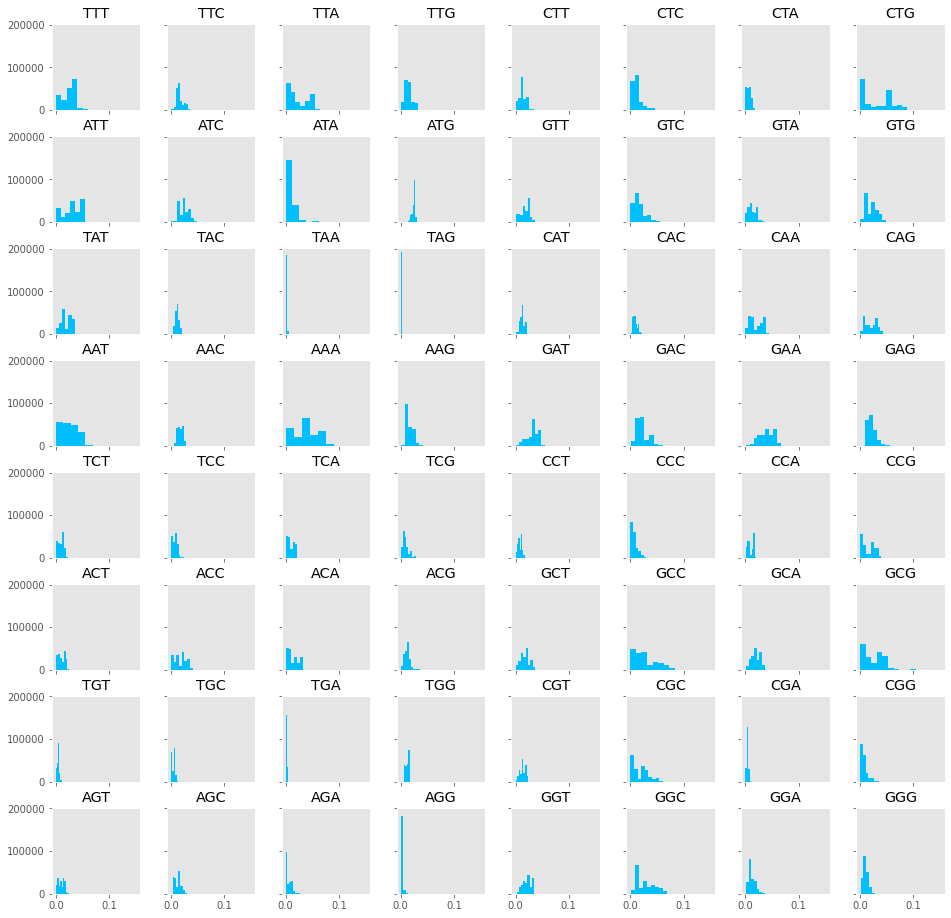

In [166]:
import matplotlib.pyplot as plt
%matplotlib inline
#visualize the data distribution
codon_hist = X.hist(grid=False, sharex=True, sharey=True, figsize=(16,16),color="deepskyblue")
plt.savefig("codon_hist.png")

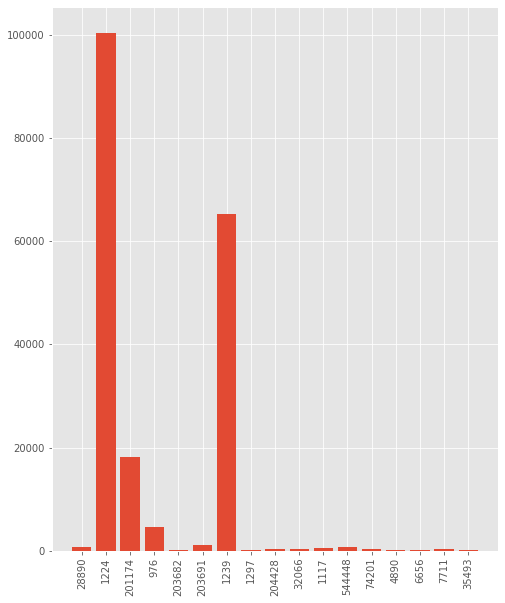

In [157]:
y_dict = Counter(y)
x_axis = []
y_axis = []
for key, value in y_dict.items():
    x_axis.append(str(key))
    y_axis.append(value)
plt.bar(x_axis,y_axis)
plt.xticks(rotation=90)
plt.show()
#plt.savefig("class_hist.png")

Side note on not normalizing and scaling the data: 

---


Due to the fact that the genome sizes and hence the number of coding sequences vary wildly from single cell organisms such as bacteria to multicellular organisms such as mammmals, I have decided to just use the percentage of each codon the input variables for the machine learning algorithms. However, this leads to a whole class of problems on its own, a field termed as compositional data analysis (CoDA). In brief, the constant sum restraint means that each variable is negatively correlated to every other variable. Furthermore, spurious correlations occurs due to the shared denominator between all variables. In statistical analysis, these spurious correlations lead to high number of false positives. In machine learning, it means that some algorithms are not suitable for the task at hand, such as Naive Bayes, which was initially used in this project. One possible solution is to transfrom the data with the class of transformation called log ratio transformation. However, how to best prepare the data and apply these transformations is an active area of research and hence I decided not to proceed with that here. 

## Training machine learning algorithms

---

In this section, we will explore 3 different machine learning algorithms for classification. They are the k-Nearest Neighbours, Random Forest, and XGBoost. All methods will be evaluated with the `classification_report` from `sklearn.metrics`, which shows the weighted F1 scores, precision and recall among others. The F1 score, which is the harmonic mean of precision and recall, is especially important in this case with imbalanced data classes. 

First, we will load in the data cleaned from before.

In [35]:
#local machine ver
import pandas as pd
import numpy as np
X = pd.read_csv("data/X_cleaned.csv", index_col=0).to_numpy()
y = pd.read_csv("data/y_cleaned.csv", index_col=0).to_numpy()

In [19]:
#colab ver
from google.colab import drive
import pandas as pd

drive.mount("/content/gdrive")
X = pd.read_csv("/content/gdrive/MyDrive/ce9010/X_cleaned.csv", index_col=0) #replace with path to your file
y = pd.read_csv("/content/gdrive/MyDrive/ce9010/y_cleaned.csv", index_col=0) #replace with path to your file

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
#have a look at the data
print(X.shape, y.shape)
print(X[1:5,1:10])

(193378, 64) (193378, 1)
[[0.01904116 0.02553228 0.0096248  0.01642443 0.01036411 0.00832686
  0.02522516 0.03339082 0.02066151]
 [0.01953535 0.0223594  0.00973007 0.0134124  0.01202618 0.00867714
  0.03043191 0.02947336 0.02187128]
 [0.01959205 0.02283034 0.00978153 0.01353999 0.01194619 0.00866733
  0.03011252 0.0299459  0.02185088]
 [0.01079056 0.04383295 0.01383745 0.01673012 0.00172699 0.00407627
  0.00581761 0.05410524 0.01173745]]


### Training k-Nearest Neighbour classifier
---
k-Nearest Neighbour is a simple algorithm that works on the principle that similar objects have similar characteristics, hence, they lie close to each other in the variable space. The class for an unknown object is assigned based on the most common class of k nearest objects. Here, we will use the default  Euclidean distance metric and vary the k variable for optimal predictive power. We will use the `StratifiedKFold` from `sklearn.model_selection` to find the best k value. 



In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report

# rename the classes
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y[:,0])

# knn k choosing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,stratify=y_encoded,test_size=0.3,random_state=42) #70% training and 30% test
skf = StratifiedKFold(n_splits=10)
k = 1
for train_index, test_index in skf.split(X_train, y_train):
    kfold_X_train = X_train[train_index,:]
    kfold_y_train = y_train[train_index]
    kfold_X_test = X_train[test_index,:]
    kfold_y_test = y_train[test_index]
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(kfold_X_train,kfold_y_train)
    preds = knn.predict(kfold_X_test)
    print(f"KNN report for {k} Nearest Neighbours:")
    print(classification_report(kfold_y_test, preds,digits=4))
    k+=1

KNN report for 1 Nearest Neighbours:
              precision    recall  f1-score   support

           0     1.0000    0.9905    0.9952       317
           1     0.9756    1.0000    0.9877        40
           2     0.9987    0.9994    0.9991      7025
           3     0.9991    0.9993    0.9992      4573
           4     1.0000    1.0000    1.0000        12
           5     1.0000    0.9333    0.9655        15
           6     1.0000    1.0000    1.0000        10
           7     1.0000    1.0000    1.0000        22
           8     1.0000    0.9808    0.9903        52
           9     1.0000    1.0000    1.0000        18
          10     0.8750    1.0000    0.9333         7
          11     1.0000    0.8947    0.9444        19
          12     0.9984    1.0000    0.9992      1266
          13     0.9167    0.9167    0.9167        12
          14     1.0000    0.9595    0.9793        74
          15     1.0000    1.0000    1.0000        28
          16     1.0000    1.0000    1.0000 

In general, the algorithm actually perform best at k = 1. As the number of neighbour to take into consideration increases, the performance of the rare classes decreases, especially class 13. Recall for class 13 fluctuates wildly, meaning that the samples from this class are classified wrongly (high number of false negatives). 

In [45]:
# knn on test set
k = 1
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train) #70% training and 30% test
preds = knn.predict(X_test)
knn_report = classification_report(y_test,preds,digits=4, output_dict=True)
print(f"Test set for {k} Nearest Neighbours:")
print(classification_report(y_test, preds,digits=4))

Test set for 1 Nearest Neighbours:
              precision    recall  f1-score   support

           0     0.9949    0.9963    0.9956      1359
           1     0.9882    0.9882    0.9882       170
           2     0.9990    0.9993    0.9992     30104
           3     0.9990    0.9992    0.9991     19598
           4     0.9800    0.9608    0.9703        51
           5     1.0000    0.9524    0.9756        63
           6     1.0000    0.9767    0.9882        43
           7     0.9894    1.0000    0.9947        93
           8     1.0000    0.9776    0.9887       223
           9     1.0000    0.9870    0.9935        77
          10     0.9697    1.0000    0.9846        32
          11     0.9737    0.9136    0.9427        81
          12     0.9982    0.9978    0.9980      5430
          13     0.9434    0.9615    0.9524        52
          14     0.9874    0.9874    0.9874       317
          15     0.9831    0.9831    0.9831       118
          16     1.0000    0.9852    0.9926   

**Expected output:**

```
Test set for 1 Nearest Neighbours:
              precision    recall  f1-score   support

           0     0.9949    0.9963    0.9956      1359
           1     0.9882    0.9882    0.9882       170
           2     0.9990    0.9993    0.9992     30104
           3     0.9990    0.9992    0.9991     19598
           4     0.9800    0.9608    0.9703        51
           5     1.0000    0.9524    0.9756        63
           6     1.0000    0.9767    0.9882        43
           7     0.9894    1.0000    0.9947        93
           8     1.0000    0.9776    0.9887       223
           9     1.0000    0.9870    0.9935        77
          10     0.9697    1.0000    0.9846        32
          11     0.9737    0.9136    0.9427        81
          12     0.9982    0.9978    0.9980      5430
          13     0.9434    0.9615    0.9524        52
          14     0.9874    0.9874    0.9874       317
          15     0.9831    0.9831    0.9831       118
          16     1.0000    0.9852    0.9926       203

    accuracy                         0.9986     58014
   macro avg     0.9886    0.9804    0.9843     58014
weighted avg     0.9986    0.9986    0.9985     58014

```

### Training Random Forest classifier


---

Random forest is an ensemble learning method that operates on the consensus of multiple decision trees. In random forest method, there are many hyperparameters to tune for optimal performance. We will use `GridSearchCV` from `sklearn.model_selection` in order to select our best parameters. As hyperparameter tuning takes a lot of time especially with such a big data set, the blow code block is only a representative example of an optimising run. The full list of hyperparameters searched are as given below:

```python
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,,20,25,30,35],
    'max_features': [10,20,25,30,32,35,38,40,45],
    'min_samples_leaf': [1,3,5,10],
    'min_samples_split': [1,3,5,10],
    'n_estimators': [25,50,75,100,125]
}
```

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,stratify=y_encoded,test_size=0.3,random_state=42) # 70% training and 30% test

param_grid = {
    'bootstrap': [True],
    'max_depth': [20,30],
    'max_features': [35],
    'min_samples_leaf': [5],
    'min_samples_split': [5],
    'n_estimators': [100]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 45.1min finished


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 35,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 100}

**Expected output**:
```
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 65.9min finished
{'bootstrap': True,
 'max_depth': 30,
 'max_features': 35,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 100}
 ```

In [47]:
# Using the best params from GridSearchCV
rf = RandomForestClassifier(n_estimators=100, max_depth=30, max_features=35,
                            min_samples_leaf=5,min_samples_split=5,random_state = 42)
rf.fit(X_train,y_train)
preds = rf.predict(X_test)
rf_report = classification_report(y_test,preds,digits=4, output_dict=True)
print(classification_report(y_test,preds,digits=4))


              precision    recall  f1-score   support

           0     0.9926    0.9875    0.9900      1359
           1     0.9880    0.9647    0.9762       170
           2     0.9971    0.9992    0.9981     30104
           3     0.9967    0.9985    0.9976     19598
           4     1.0000    0.9608    0.9800        51
           5     0.9828    0.9048    0.9421        63
           6     1.0000    0.9535    0.9762        43
           7     1.0000    1.0000    1.0000        93
           8     0.9950    0.9013    0.9459       223
           9     0.9737    0.9610    0.9673        77
          10     1.0000    1.0000    1.0000        32
          11     1.0000    0.7531    0.8592        81
          12     0.9948    0.9954    0.9951      5430
          13     0.9189    0.6538    0.7640        52
          14     1.0000    0.9558    0.9774       317
          15     0.9646    0.9237    0.9437       118
          16     1.0000    0.9704    0.9850       203

    accuracy              

### Training XGBoost classifier


---


XGBoost is another ensemble method, where gradient boosting is incorporated to improve performance. This is done via gradient descent hence the name. Additionally, XGBoost gives the option of performing regularisation, preventing overfitting. We will utilise the hyperparameters fround from Random Forest and see if there is improvement with XGBoost. 

In [37]:
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# rename the classes
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,stratify=y_encoded,test_size=0.2,random_state=42) # 80% training and 20% test
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train,stratify=y_train,test_size=0.25,random_state=42) # 60% training and 20% eval
dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_eval, label=y_eval)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {"objective":"multi:softmax", "n_estimators":100, "max_depth":30, 
         "min_child_weight":5,"lambda":1.5, "alpha":1," colsample_bytree":35/64, 
         "learning_rate":0.1, "num_class":17}
evallist = [(dtrain, 'train'),(deval, 'eval')]
xg_reg = xgb.train(param,dtrain,num_boost_round=1000,evals=evallist,early_stopping_rounds=10)

ve cases.


[12:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:2.04129	eval-mlogloss:2.04422
[1]	train-mlogloss:1.68487	eval-mlogloss:1.68907
[2]	train-mlogloss:1.43961	eval-mlogloss:1.44458
[3]	train-mlogloss:1.25183	eval-mlogloss:1.25728
[4]	train-mlogloss:1.10043	eval-mlogloss:1.10616
[5]	train-mlogloss:0.97439	eval-mlogloss:0.98065
[6]	train-mlogloss:0.86717	eval-mlogloss:0.87379
[7]	train-mlogloss:0.77480	eval-mlogloss:0.78172
[8]	train-mlogloss:0.69442	eval-mlogloss:0.70150
[9]	train-mlogloss:0.62391	eval-mlogloss:0.63116
[10]	train-mlogloss:0.56171	eval-mlogloss:0.56914
[11]	train-mlogloss:0.50653	eval-mlogloss:0.51410
[12]	train-mlogloss:0.45732	eval-mlogloss:0.46506
[13]	train-mlogloss:0.41346	eval-mlogl

In [38]:
preds = xg_reg.predict(dtest)

# evaluate predictions
xgb_report = classification_report(y_test,preds,digits=4, output_dict=True)
print(classification_report(y_test,preds,digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9978    0.9989       906
           1     1.0000    0.9649    0.9821       114
           2     0.9987    0.9996    0.9991     20069
           3     0.9986    0.9992    0.9989     13065
           4     1.0000    1.0000    1.0000        34
           5     0.9756    0.9524    0.9639        42
           6     1.0000    0.9310    0.9643        29
           7     1.0000    1.0000    1.0000        62
           8     1.0000    0.9664    0.9829       149
           9     1.0000    0.9804    0.9901        51
          10     1.0000    1.0000    1.0000        21
          11     1.0000    0.9444    0.9714        54
          12     0.9986    0.9975    0.9981      3620
          13     0.9375    0.8571    0.8955        35
          14     0.9766    0.9905    0.9835       211
          15     0.9750    0.9873    0.9811        79
          16     1.0000    0.9704    0.9850       135

    accuracy              

## Evaluating Classifiers

---

We collated all the classification reports from the three algorithms and plot their performances.

In [119]:
weighted_accuracy = {"knn":knn_report["weighted avg"]["f1-score"],
                    "rf":rf_report["weighted avg"]["f1-score"],
                    "xgb":xgb_report["weighted avg"]["f1-score"]}
pprint.pprint(weighted_accuracy)
#set up lists
knn_precision = []
knn_recall = []
knn_f1 = []
rf_precision = []
rf_recall = []
rf_f1 = []
xgb_precision = []
xgb_recall = []
xgb_f1 = []
for i in range(17):
    knn_precision.append(knn_report[str(i)]["precision"])
    knn_recall.append(knn_report[str(i)]["recall"])
    knn_f1.append(knn_report[str(i)]["f1-score"])
    rf_precision.append(rf_report[str(i)]["precision"])
    rf_recall.append(rf_report[str(i)]["recall"])
    rf_f1.append(rf_report[str(i)]["f1-score"])
    xgb_precision.append(xgb_report[str(i)]["precision"])
    xgb_recall.append(xgb_report[str(i)]["recall"])
    xgb_f1.append(xgb_report[str(i)]["f1-score"])


{'knn': 0.9985486269024265, 'rf': 0.9964272573280986, 'xgb': 0.9984402305054061}


In [117]:
#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

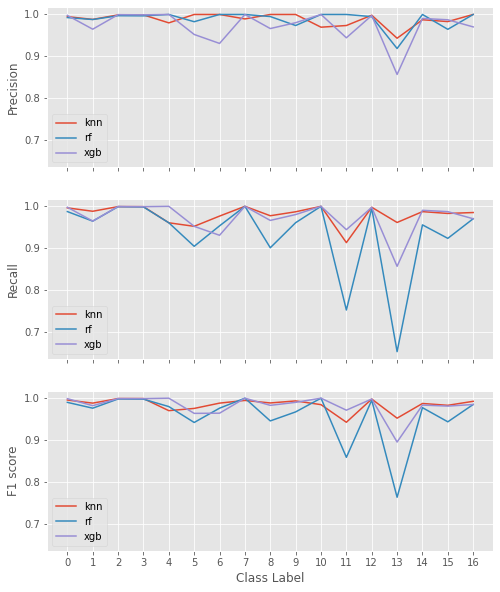

In [120]:
plt.rcParams['figure.figsize'] = (8,10)
fig = plt.figure()
gs = fig.add_gridspec(3)
(ax1,ax2,ax3) = gs.subplots(sharex=True, sharey=True)
ax1.plot(x_axis, knn_precision, label="knn")
ax1.plot(x_axis, rf_precision, label="rf")
ax1.plot(x_axis, xgb_recall, label="xgb")
ax2.plot(x_axis, knn_recall, label="knn")
ax2.plot(x_axis, rf_recall, label="rf")
ax2.plot(x_axis, xgb_recall, label="xgb")
ax3.plot(x_axis, knn_f1, label="knn")
ax3.plot(x_axis, rf_f1, label="rf")
ax3.plot(x_axis, xgb_f1, label="xgb")
ax1.legend()
ax2.legend()
ax3.legend()
ax3.set_xlabel("Class Label")
ax1.set_ylabel("Precision")
ax2.set_ylabel("Recall")
ax3.set_ylabel("F1 score")
ax3.set_xticks(x_axis)
plt.show()
#plt.savefig("metrics.png")

We can observe that although the algorithms performed well according to the weighted f1 scores, they seems to struggle particularly with class 11 and class 13 with a noticable drop in both precision and recall. 

In [122]:
#get actual phylum for classes 11 and 13
print("Taxid for 11 is", le.inverse_transform([11]))
print("Number of examples belonging to taxid",le.inverse_transform([11]) , "is", sum(y_encoded[y_encoded == 11]))
print("Taxid for 13 is", le.inverse_transform([13]))
print("Number of examples belonging to taxid",le.inverse_transform([13]) , "is", sum(y_encoded[y_encoded == 13]))

Taxid for 11 is [74201]
Number of examples belonging to taxid [74201] is 2959
Taxid for 13 is [203682]
Number of examples belonging to taxid [203682] is 2275


The taxonomy ID 74201 belongs to Verrucomicrobia. Species from the Verrucomicrobia have been detected in many different environments. They are known to vary wildly in genome sizes and in their physiological properties even when sampled from the same overall environment (10.3389/fmicb.2017.02131). Meanwhile, the taxonomy ID 203682 belongs to Planctomycetes, with 2275 samples in our data. Planctomycetes have been known to occupy diverse niches, and are very metabolically flexible. Their flexibilty may lead to them having very different codon usage within the phylum itself. Both Verrucomicrobia and Planctomycetes belong to the same monophyletic group, meaning they shared a common ancestor. This may play a part in the misclassification going on. 

The high precision and low recall means that the rate of false negatives is high for class 11 and 13. It could mean that the 2 classes do possess unique codon usage patterns that are indicative but is not present in all samples of the class. 